In [1]:
import os
import pandas as pd
from pandas import DataFrame
import re
import numpy as np
import random
import nltk
from nltk import word_tokenize
from typing import List, Dict, Any
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/mynguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Parsing: NYT article headline

In [ ]:
PATH = "../dataset/"
domain = "article"
file = "nyt/nyt-articles-2020.csv"
file_path = os.path.join(PATH,domain,file)


In [ ]:
dataframe = pd.read_csv(file_path).reset_index()

In [ ]:
# get Headline and second headline
dataframe.head()

In [ ]:
top_newdesks = dataframe.newsdesk.value_counts()
# .index[:5]
print(top_newdesks)

top_newdesks = ["Business"]

In [ ]:
dataframe_filtered = dataframe[dataframe["newsdesk"].isin(top_newdesks)].copy()

In [ ]:
dataframe_headline = dataframe_filtered[["index", "headline"]].copy()

In [ ]:
dataframe_headline.head()

For Sentences, we need to first create a dictionary for all the words appear in the model.
So the number of words in the dictionary will be the number of neurons in the input layer

In [ ]:
test_str = "It's, raining.?"

re.sub("\?|\.|\,", "", test_str)

In [ ]:
# Let's not worry about punctuation right now
# but punctuation can help with formulating grammar
dataframe_headline["headline"] = dataframe_headline["headline"].apply(lambda x: re.sub("\'|\!|\?|\.|\|\(|\)|\,|\(|\)", "", x))

In [ ]:
dataframe_headline["headline"].head()

### Parsing: dialogs

In [ ]:
PATH = "../dataset/"
domain = "chat"
file = "dialogs.txt"
file_path = os.path.join(PATH,domain,file)


In [ ]:
# read text data
with open(file_path, mode="r") as file:
    rows = file.readlines()
    rows = [row.replace("\t"," ").replace("\n", "") for row in rows]
    sentences = [nltk.sent_tokenize(row)[0] for row in rows]
    dataframe = pd.DataFrame(sentences, columns=["message"]).reset_index()

In [ ]:
dataframe.shape

In [ ]:
dataframe["message"] = dataframe["message"].apply(lambda x: re.sub("\'|\!|\?|\.|\|\(|\)|\,|\(|\)", "", x))

### Question Answer

In [2]:
PATH = "../dataset/"
domain = "qa"
file = "S08_question_answer_pairs.txt"
file_path = os.path.join(PATH,domain,file)

In [3]:
with open(file_path, mode="r") as file:
    dataframe = pd.read_csv(file, delimiter="\t").reset_index()

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     1715 non-null   int64 
 1   ArticleTitle              1715 non-null   object
 2   Question                  1696 non-null   object
 3   Answer                    1475 non-null   object
 4   DifficultyFromQuestioner  1224 non-null   object
 5   DifficultyFromAnswerer    1473 non-null   object
 6   ArticleFile               1713 non-null   object
dtypes: int64(1), object(6)
memory usage: 93.9+ KB


In [5]:
dataframe.head()

,index,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,S08_set3_a4
1,1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,S08_set3_a4
2,2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,S08_set3_a4
3,3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,S08_set3_a4
4,4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,S08_set3_a4


In [6]:
# lower case col
dataframe.columns = [col.lower() for col in dataframe.columns] 

In [7]:
# lower case value
dataframe.question = dataframe.question.apply(lambda x: str(x).lower())

In [8]:
# remove punctuation
dataframe["question"] = dataframe["question"].apply(lambda x: re.sub("\!|\?|\|\(|\)|,|\(|\)", "", x))
dataframe["question"] = dataframe["question"].apply(lambda x: re.sub("-rrb-", "", x))
dataframe["question"] = dataframe["question"].apply(lambda x: re.sub("-lrb-", "", x))
dataframe["question"] = dataframe["question"].apply(lambda x: re.sub("[^a-zA-z0-9\s]", "", x))

In [9]:
dataframe.head()

,index,articletitle,question,answer,difficultyfromquestioner,difficultyfromanswerer,articlefile
0,0,Abraham_Lincoln,was abraham lincoln the sixteenth president of...,yes,easy,easy,S08_set3_a4
1,1,Abraham_Lincoln,was abraham lincoln the sixteenth president of...,Yes.,easy,easy,S08_set3_a4
2,2,Abraham_Lincoln,did lincoln sign the national banking act of 1863,yes,easy,medium,S08_set3_a4
3,3,Abraham_Lincoln,did lincoln sign the national banking act of 1863,Yes.,easy,easy,S08_set3_a4
4,4,Abraham_Lincoln,did his mother die of pneumonia,no,easy,medium,S08_set3_a4


In [10]:
print(dataframe[dataframe["question"].str.contains("21698181")]["question"].values)

['is it true that romania has a population of 21698181']


### Proccessing

In [11]:
# Generate dictionary of words coming from the source data

def create_vocab_mapping(sequences):
    """
    from input sequences of tokens for each string, add to dictionary
    """
    vocabulary_mapping = {}
    list_of_vocab = {}
    index_cnt = 0

    for words in sequences:
        for token in words:
            try:
                list_of_vocab[token] += 1
            except Exception as error:
                list_of_vocab[token] = 1

    # creating vocab
    randomized_list_of_vocab = list(list_of_vocab.keys())
    random.shuffle(randomized_list_of_vocab)
    
    for word in randomized_list_of_vocab:
        vocabulary_mapping[index_cnt] = word
        index_cnt += 1
    return vocabulary_mapping, list_of_vocab

def create_tokens(dataframe, column) -> List[str]:
    """
    From column in a dataframe, process each input string
    and return a list of tokens
    """
    dataframe_processing = dataframe[column]
    dataframe_processing = dataframe_processing.drop_duplicates()
    sentences = []

    for row in dataframe_processing:
        words = word_tokenize(row)
        words.append("</s>")
        sentences.append(words)

    # randomize input sentences for training
    random.shuffle(sentences)
    return sentences


In [12]:
def count_words():
    """
    Return Frequency of words in a dataset, and number of 
    sentences containing those words
    """
    pass

In [13]:
sentences = create_tokens(dataframe, "question")
vocabulary_mapping, list_of_vocab = create_vocab_mapping(sentences)
input_size = len(vocabulary_mapping)
input_size

2580

In [14]:
# dict(sorted(list_of_vocab.items(), key=lambda item: item[0]))


In [15]:
vocabulary_mapping

{0: 'global',
 1: 'international',
 2: 'generally',
 3: 'blue',
 4: 'unjust',
 5: 'almost',
 6: 'thriving',
 7: 'supreme',
 8: 'breckinridge',
 9: 'rich',
 10: 'prefer',
 11: 'host',
 12: 'sympathetic',
 13: 'balance',
 14: 'peoples',
 15: 'actually',
 16: 'field',
 17: 'statute',
 18: 'indonesia',
 19: 'temperate',
 20: 'do',
 21: 'herbivores',
 22: 'travel',
 23: 'psi',
 24: '2003',
 25: 'hungarian',
 26: 'also',
 27: 'squid',
 28: 'turn',
 29: 'start',
 30: 'independent',
 31: 'wifes',
 32: 'six',
 33: 'games',
 34: 'capital',
 35: 'h',
 36: 'pythons',
 37: 'surrealist',
 38: 'placed',
 39: 'primarily',
 40: 'decrease',
 41: 'wider',
 42: 'visited',
 43: 'revolution',
 44: 'eighth',
 45: 'carlos',
 46: 'yew',
 47: 'originally',
 48: '20',
 49: 'dabbling',
 50: 'was',
 51: 'shell',
 52: 'fatherinlaw',
 53: 'dawlat',
 54: 'series',
 55: 'whether',
 56: 'blubber',
 57: 'ghanas',
 58: 'hearing',
 59: 'until',
 60: 'day',
 61: 'graduating',
 62: 'purchase',
 63: 'hart',
 64: 'describes',

### Encoding

In [16]:
import torch

/Users/mynguyen/Repos/language-helper/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
def find_word_index(word):
    """
    Look up word index in vocabulary dictionary
    """
    value = [index for index in vocabulary_mapping.keys() if vocabulary_mapping[index] == word]
    return value[0]


def sentence_to_tensor(sentences):
    tensor = torch.zeros(len(sentences), 1, len(vocabulary_mapping))
    for sentence, word in enumerate(sentences):
        index = find_word_index(word)
        tensor[sentence][0][index] = 1
    return tensor


def formulate_target(sentences: List[str]):
    """
    For example:
    string: This is a test

    embedded tensor:
    This = [[[]]]

    target: is
    """
    orig_size = len(sentences)
    x_sentence = sentences[:-1]
    y_sentence = sentences[1:]
    x_tensor = sentence_to_tensor(sentences=x_sentence)
    y_tensor = sentence_to_tensor(sentences=y_sentence)
    return x_tensor, y_tensor



In [18]:
# 996: 'Biking'
find_word_index("president")

854

In [19]:
print(f"Input: {sentences[0]}")
tensor = sentence_to_tensor(sentences[0])

Input: ['was', 'abraham', 'lincoln', 'the', 'sixteenth', 'president', 'of', 'the', 'united', 'states', '</s>']


In [20]:
print(tensor.shape)

torch.Size([11, 1, 2580])


In [21]:
x_tensor, y_tensor = formulate_target(sentences=sentences[0])

In [22]:
x_tensor.shape

torch.Size([10, 1, 2580])

In [23]:
y_tensor.shape

torch.Size([10, 1, 2580])

### Building Models

In [24]:
import torch.nn as nn
from torch.autograd import Variable
from torch import FloatTensor, randn, zeros

In [25]:
INPUT_SIZE = len(vocabulary_mapping)
HIDDEN_SIZE = 128
OUPUT_SIZE = len(vocabulary_mapping)
LEARNING_RATE = 0.005

In [26]:
class RNN(nn.Module):
    """
    simple RNN network with 1 layer
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.dropout(output)
        # output = self.softmax(output)
        return output, hidden
        
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

### Training Model

In [27]:
# Demonstrating how model interact
def predict(input_sentence, rnn):
    # rnn.eval()
    hidden = rnn.init_hidden()
    x_input = sentence_to_tensor(input_sentence)
    x_input = Variable(x_input)
    
    hidden = Variable(torch.zeros(1, HIDDEN_SIZE))
    output, next_hidden = rnn(x_input[0], hidden)

    # get the token probabilities
    p = torch.nn.functional.softmax(output, dim=1).data
    return output, p

#### What is Backpropagation in LSTM's language model


#### What is Issue of Vanishing Gradient


#### What is CrossEntropyLoss for LSTM's language model


#### What is the Optimizer we can use in LSTM


#### What is checkpoint


In [39]:
# training

#  initialize rnn instance
rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, OUPUT_SIZE)
n_iterations = 400
hidden = rnn.init_hidden()
rnn.zero_grad()

total_loss = 0
training_result = []

# measuring differences between predicted probability distribution 
# versus the actual
criterion = nn.CrossEntropyLoss()



# define an optimizer
rnn.train()

# define epoch for training
# for each iteration, pick a sentence for training
for iter in range(1, n_iterations+1):
    hidden = rnn.init_hidden()

    # select an input for training
    loss = 0
    # sentence = np.random.choice(sentences)
    sentence = sentences[iter]
    
    # wrap tensor in Variable
    x_tensor, y_tensor = formulate_target(sentence)
    x_tensor = Variable(x_tensor)
    y_tensor = Variable(y_tensor)

    for index in range(x_tensor.size()[0]):
        # zero gradient
        rnn.zero_grad()
        output, hidden = rnn(x_tensor[index], hidden)

        # to evaluate output, we need to compare generated output
        # against the actual next word
       
        # after training each word in input sequence, calculate loss
        loss += criterion(output, y_tensor[index])

        # https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time/6795/2
        # To reduce memory usage, during the .backward() call, all the intermediary results
        # are deleted when they are not needed anymore. Hence if you try to call .backward() again,
        # the intermediary results don’t exist and the backward pass cannot be performed (and you get the error you see).
        # You can call .backward(retain_graph=True) to make a backward pass that will not delete intermediary results
    
        loss.backward(retain_graph=True)

        nn.utils.clip_grad_norm_(rnn.parameters(), 1)
        # update weights
        
        for p in rnn.parameters():
            try:
                p.data.sub_(-LEARNING_RATE, p.grad.data)
            except Exception as e:
                print("Skipping")

        # average the training loss for the sentence (due to sentence might have more token)
        loss = loss/x_tensor.size()[0]


    # early stopping if loss stop decreasing
    # https://github.com/Bjarten/early-stopping-pytorch
    
    print(f"Iter {iter}")
    print(f"Loss {loss}")

    # only adding total loss training for each sentence to training result
    training_result.append(float(loss.data))
    

Skipping
Skipping
Iter 1
Loss 0.982056200504303
Iter 2
Loss 1.5703843832015991
Iter 3
Loss 1.313876986503601
Iter 4
Loss 1.3131552934646606
Iter 5
Loss 0.9855276942253113
Iter 6
Loss 1.570529580116272
Iter 7
Loss 0.8771093487739563
Iter 8
Loss 0.8772533535957336
Iter 9
Loss 0.8773318529129028
Iter 10
Loss 1.125866413116455
Iter 11
Loss 1.317627191543579
Iter 12
Loss 1.579384684562683
Iter 13
Loss 1.317681908607483
Iter 14
Loss 3.8106448650360107
Iter 15
Loss 1.3211009502410889
Iter 16
Loss 0.7918581366539001
Iter 17
Loss 1.3194301128387451
Iter 18
Loss 0.9905327558517456
Iter 19
Loss 1.3093825578689575
Iter 20
Loss 0.9930765628814697
Iter 21
Loss 1.5874096155166626
Iter 22
Loss 1.130326509475708
Iter 23
Loss 1.5875147581100464
Iter 24
Loss 0.9926241636276245
Iter 25
Loss 1.3238898515701294
Iter 26
Loss 1.5861376523971558
Iter 27
Loss 0.662434458732605
Iter 28
Loss 1.9884507656097412
Iter 29
Loss 0.872712254524231
Iter 30
Loss 0.9962291717529297
Iter 31
Loss 0.9951757788658142
Iter 32
L

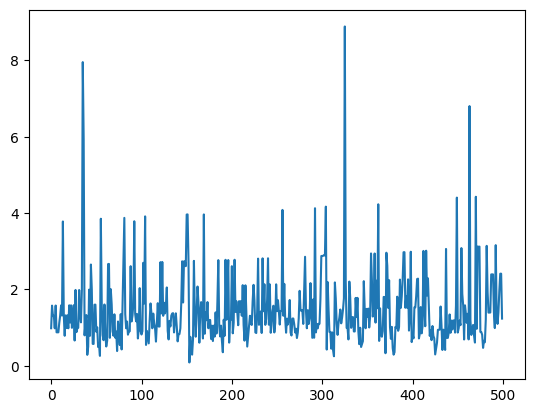

In [38]:
from matplotlib import pyplot as plt

plt.plot(training_result)
plt.show()

In [ ]:
x_input = sentence_to_tensor(["is"])
x_input = Variable(x_input)
x_input[0]

In [ ]:
# predict
result = {}
output, p = predict(["is"], rnn)

# print top 5 results
print(vocabulary_mapping[int(output.data.topk(5).indices[0])])

# top 5 categories
result[sentences[index][0]] = vocabulary_mapping[int(output.data.topk(2).indices[0][0])]


In [ ]:
result.values()

### Evalutation

In [ ]:
output, p = predict(sentences[1], rnn)

In [ ]:
output.data.topk(1)


In [ ]:
for name, p in rnn.named_parameters():
    print(name)
    print(p)

In [ ]:
vocabulary_mapping[len(vocabulary_mapping)-1]